# Chp10. Grouping unlabeled items using k-means clustering

- **발표자 : 정지원**
- **날짜 : 2017.2.18(토)**

---

### ** This chapter covers **
- The k-means clustering algorithm
- Cluster postprocessing
- Bisecting k-means
- Clustering geographic points

예전 미국 대선 때의 이야기다. 가장 많은 표를 얻은 주가 50.7%였다. 그리고 가장 낮은 득표율이 47.9%다. 만약에 퍼센트가 조금이라도 변한다면 선거의 결과 자체가 달라질 수도 있다는 얘기다. 자신을 지지하지 않는 소수의 사람의 마음을 바꿔 놓는다면, 결과가 바뀔 수도 있다. 그렇다면 그러한 그룹을 어떻게 찾을까? 그래서 어떻게 제한된 예산으로 그들의 마음을 바꿀까? 정답은 _clustering_에 있다.

어떻게 클러스터링을 하면 될까? 먼저 사람들의 정보를 통하여 그들이 어떻게 투표를 하는지에 대해 살펴봐야 한다. 그리고 그 사람들의 정보를 클러스터링 한 후, 어느 그룹에 메시지를 전달하는 것이 가장 좋을지를 결정하면 된다.

클러스터링은 유사한 것들끼리 자동으로 클러스터링을 형성하게 해주는 비지도학습(unsupervised learning)이다. 클러스터는 클러스터 내에 유사한 것들이 모이면 모일수록 좋아진다고 할 수 있다. 이번 챕터에서, _k-means_라 불리는 클러스터링 알고리즘에 대해 공부한다. _k-means_는 _k_개의 unique clusters를 구해준다. 클러스터안의 value의 평균이 클러스터 중심점이다.

데이터가 있다고 하자. 유사한 것들끼리 묶고 그룹에 대해 구하려면 어떻게 해야할까? classification는 무엇을 찾고 싶어하는지를 알고 행하는 반면에, clustering은 그렇지 않다. 또한 predefined classes도 가지고 있지 않다. 그래서 clustering을 _unsupervised classification_이라고도 한다.

클러스터분석에서 우리는 유사한 것들을 같은 클러스터에, 유사하지 않은 것들을 다른 클러스터에 놓고 싶어한다. 여기서 similarity는 유사도 측정을 통해 구해진다. 이전 챕터에서는 좀 다른 similarity measure을 봤을텐데, 이는 뒤에 챕터에서도 나오는 것이고 어디에 적용하냐에 따라 다르게 쓰인다.

k-means 알고리즘을 더 자세히 살펴보자.

## 10.1 The k-means clustering algorithm

![Images](figures/1.png)

k-means는 주어진 데이터에서 k개의 clusters를 찾는 것이다. k는 user가 정해주면 된다. 각 클러스터마다 _centroid_라 부르는 하나의 점이 존재한다. Centroid는 그 클러스터내의 모든 점들의 center를 의미한다.

k-means 알고리즘은 다음과 같이 작동한다. 먼저 k개의 centroids를 랜덤하게 정한다. 그리고서 각 점들을 하나의 클러스터에 대응시킨다. 대응은 가장 가까운 centroids의 cluster에 속하도록 한다. 이 과정을 거친 후 centroids는 모두 업데이트가 된다.

![Images](figures/2.png)

여기서 가장 가까운 centroid라는 것이 어떻게 정의되는지 생각해보자. 이는 몇 가지의 distance measure를 함축한다. k-means의 성능은 이렇게 사용한 distance measure에 의해 결정된다. 코드를 짜기 전에, 다음을 보자.

In [1]:
from numpy import *

def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = map(float,curLine)
        dataMat.append(fltLine)
    return dataMat

def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))

def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))
    for j in range(n):
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k,1)
    return centroids

In [2]:
datMat = mat(loadDataSet('testSet.txt'))
datMat

matrix([[ 1.658985,  4.285136],
        [-3.453687,  3.424321],
        [ 4.838138, -1.151539],
        [-5.379713, -3.362104],
        [ 0.972564,  2.924086],
        [-3.567919,  1.531611],
        [ 0.450614, -3.302219],
        [-3.487105, -1.724432],
        [ 2.668759,  1.594842],
        [-3.156485,  3.191137],
        [ 3.165506, -3.999838],
        [-2.786837, -3.099354],
        [ 4.208187,  2.984927],
        [-2.123337,  2.943366],
        [ 0.704199, -0.479481],
        [-0.39237 , -3.963704],
        [ 2.831667,  1.574018],
        [-0.790153,  3.343144],
        [ 2.943496, -3.357075],
        [-3.195883, -2.283926],
        [ 2.336445,  2.875106],
        [-1.786345,  2.554248],
        [ 2.190101, -1.90602 ],
        [-3.403367, -2.778288],
        [ 1.778124,  3.880832],
        [-1.688346,  2.230267],
        [ 2.592976, -2.054368],
        [-4.007257, -3.207066],
        [ 2.257734,  3.387564],
        [-2.679011,  0.785119],
        [ 0.939512, -4.023563],
        

In [3]:
datMat.shape

(80, 2)

In [4]:
min(datMat[:,0])

matrix([[-5.379713]])

In [5]:
min(datMat[:,1])

matrix([[-4.232586]])

In [6]:
max(datMat[:,1])

matrix([[ 5.1904]])

In [7]:
max(datMat[:,0])

matrix([[ 4.838138]])

In [8]:
randCent(datMat, 2)

matrix([[ 3.1858579 ,  1.54257277],
        [ 2.13382358, -2.2321309 ]])

In [9]:
distEclud(datMat[0], datMat[1])

5.184632816681332

In [10]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        print centroids
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]#get all the point in this cluster
            centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean 
    return centroids, clusterAssment

clusterAssment는 (m*2) 행렬이다. 2개의 columns중 하나는 어느 클러스터에 속할지 인덱스를 저장, 하나는 Squared Error를 보관한다.

clusterChanged를 비교하여 클러스터가 변하는 것이 하나라도 존재하면 true값을 갖게 된다. for문을 돌면서 하나도 변하지 않는다면 더 이상의 변화가 없으므로 while문을 종료한다.

![Images](figures/3.png)

마침내 루프를 돌고 모두 업데이트가 된다. centroids는 cluster의 all value의 mean값을 갖게 된다.

In [11]:
datMat = mat(loadDataSet('testSet.txt'))

In [12]:
myCentroids, clustAssing = kMeans(datMat,4)
myCentroids

[[ 2.81437545 -1.48639819]
 [-0.06141975  0.25932728]
 [ 1.58362351  2.87148742]
 [-1.35838578  3.16880918]]
[[ 2.81706052 -2.71370657]
 [-3.29665957 -2.60368495]
 [ 2.54391447  3.21299611]
 [-2.45009747  2.89275747]]
[[ 2.80293085 -2.7315146 ]
 [-3.38237045 -2.9473363 ]
 [ 2.6265299   3.10868015]
 [-2.46154315  2.78737555]]


matrix([[ 2.80293085, -2.7315146 ],
        [-3.38237045, -2.9473363 ],
        [ 2.6265299 ,  3.10868015],
        [-2.46154315,  2.78737555]])

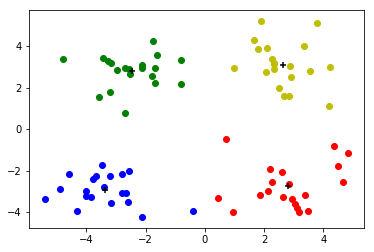

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter([datMat[i,0] for i in range(80) if clustAssing[i,0] == 0.],[datMat[i,1] for i in range(80) if clustAssing[i,0] == 0.],color='r')
plt.scatter([datMat[i,0] for i in range(80) if clustAssing[i,0] == 1.],[datMat[i,1] for i in range(80) if clustAssing[i,0] == 1.],color='b')
plt.scatter([datMat[i,0] for i in range(80) if clustAssing[i,0] == 2.],[datMat[i,1] for i in range(80) if clustAssing[i,0] == 2.],color='y')
plt.scatter([datMat[i,0] for i in range(80) if clustAssing[i,0] == 3.],[datMat[i,1] for i in range(80) if clustAssing[i,0] == 3.],color='g')
plt.scatter([myCentroids[i,0] for i in range(4)],[myCentroids[i,1] for i in range(4)],marker='+',color='black')
plt.show()

4번 iterations 후에 끝난다.

## 10.2 Improving cluster performance with postprocessing

k는 user가 정해줬는데, 이 k가 얼마나 right한가? 우리는 어떤 클러스터를 보고 좋은 클러스터링이라 할 수 있는가? 좋은 클러스터는 각 점마다의 error를 통해 평가할 수 있다.

아래 사진을 보자. k-means가 수렴하였다. 하지만 썩 좋아보이지 않는다. 이유는 global minimum이 아닌 local minimum에 수렴해버렸기 때문이다.

![Images](figures/4.png)

SSE(sum of squared error)를 통하여 클러스터 할당이 잘 됐는지를 평가한다. 이 값들은 작을수록 더 좋은 클러스터링이라 할 수 있다. 이 값을 줄이려면? 단순히 클러스터의 수를 늘리면 된다. 하지만 그러면 우리의 주 목적(클러스터:의미있는 집단을 찾는 것)이랑 상반된다. 그렇다면 k의 값은 유지하면서 SSE를 줄이기 위한 방법은 무엇이 있을까?

후처리를 해줄수도 있다. 가장 높은 SSE값을 갖는 클러스터를 2개의 클러스터로 나누는 것이다. 그 클러스터를 따로 받아서 k=2인 클러스터링을 하면 된다.

다시 원래대로 돌리려면 merge하면 된다. 우리는 위 그림에서 잘못된 centroids를 쉽게 볼 수 있다. 하지만 이것은 2차원이라 그런데, 만약 40차원이라면 어쩔 것인가?

(1)가장 가까운 centroids를 merge하거나 (2)total SSE를 가장 줄여줄 수 있는 두 centroids를 merge하는 방식이 있다. (1)은 모든 centroids 사이의 거리를 구해보면 되고, (2)는 모든 경우의 수(pairs)의 total SSE를 비교해보는 것이다.

## 10.3 Bisecting k-means

위와 같이 k-means 알고리즘이 local minimum에 빠지는 문제를 극복하기 위해 또 다른 알고리즘이 개발됐다. _bisecting k-means_는 하나의 클러스터로 시작해서 2개로 나눈다. 그러고서 어떤 cluster를 split할지 정한다. SSE를 minimize하는 방향으로 선택하게 된다. 이 알고리즘은 user가 정한 k개의 clusters로 나눠질 때까지 계속해서 split하게 된다.

또 다른 방법은 largest SSE를 갖는 cluster를 선택하고 이것이 k개의 clusters가 될 때까지 split하는 것이다. 다음 코드를 살펴보자.

In [14]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m):#calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print "sseSplit, and notSplit: ",sseSplit,sseNotSplit
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print 'the bestCentToSplit is: ',bestCentToSplit
        print 'the len of bestClustAss is: ', len(bestClustAss)
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return mat(centList), clusterAssment

우선 전체 데이터셋을 통하여 하나의 centroid를 정한다. 정해진 것을 가지고 all data에 대해 centroid와 error를 구해준 후 시작한다.

while루프를 돌면서 kMeans 함수를 통해 클러스터링을 해준다. 원하는 k개로 나눠질 때까지 실행한다. 처음에는 lowest SSE를 infinity로 설정한다. k-means를 통해 2개의 new centroids와 SSE를 얻을 수 있다. 계속해서 while문을 돌면서 lowest SSE를 반환하는 split을 찾는다. 마침내 새로운 cluster assignment를 정하게 되면, _centList_에 append하게 된다.

while 루프가 끝나면, 원하는 centroid list와 cluster assignments를 얻을 수 있다.

In [15]:
datMat3=mat(loadDataSet('testSet2.txt'))

In [16]:
centList,myNewAssments=biKmeans(datMat3,3)

[[-0.65381793  2.23434163]
 [-3.06858565  2.35140363]]
[[ 1.12342729  0.311763  ]
 [-3.14707283  3.35698672]]
[[ 1.23710375  0.17480612]
 [-2.94737575  3.3263781 ]]
sseSplit, and notSplit:  570.722757425 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
[[-1.70953483 -3.33248341]
 [ 4.10495908  1.54478148]]
[[-0.45965615 -2.7782156 ]
 [ 2.93386365  3.12782785]]
sseSplit, and notSplit:  68.6865481262 38.0629506357
[[-3.18228204  3.88171658]
 [-3.50097264  4.28406847]]
[[-2.60978588  3.02149719]
 [-4.29773525  4.54590175]]
sseSplit, and notSplit:  21.5094070749 532.659806789
the bestCentToSplit is:  0
the len of bestClustAss is:  40


In [17]:
centList

matrix([[-0.45965615, -2.7782156 ],
        [-2.94737575,  3.3263781 ],
        [ 2.93386365,  3.12782785]])

In [18]:
myNewAssments.shape

(60, 2)

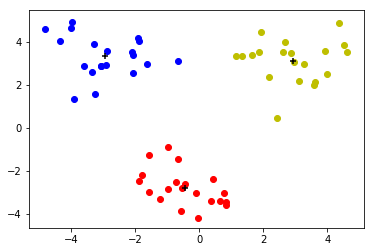

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter([datMat3[i,0] for i in range(60) if myNewAssments[i,0] == 0.],[datMat3[i,1] for i in range(60) if myNewAssments[i,0] == 0.],color='r')
plt.scatter([datMat3[i,0] for i in range(60) if myNewAssments[i,0] == 1.],[datMat3[i,1] for i in range(60) if myNewAssments[i,0] == 1.],color='b')
plt.scatter([datMat3[i,0] for i in range(60) if myNewAssments[i,0] == 2.],[datMat3[i,1] for i in range(60) if myNewAssments[i,0] == 2.],color='y')
plt.scatter([datMat3[i,0] for i in range(60) if myNewAssments[i,0] == 3.],[datMat3[i,1] for i in range(60) if myNewAssments[i,0] == 3.],color='g')
plt.scatter([centList[i,0] for i in range(3)],[centList[i,1] for i in range(3)],marker='+',color='black')
plt.show()

![Image](figures/5.png)

## 10.4 Example: clustering points on a map

친구인 Drew가 생일이라 town을 구경하길 원한다. 70곳의 가고싶은 지역 리스트를 내게 줬다. 클러스터링을 해서 생각해보려 했는데, 주소가 위도/경도 좌표가 아닌 주소기 때문에 거리를 계산할 수가 없다. 위도와 경도를 얻기 위해 어떻게 해야할까?

![Image](figures/6.png)

address를 latitude와 longitude로 바꿔주는 서비스가 필요하다. Yahoo가 제공한다.

### 10.4.1 The Yahoo! PlaceFinder API

The wonderful people at Yahoo! have provided a free API that will return a latitude and longitude for a given address. You can read more about it at the following URL: http://developer.yahoo.com/geo/placefinder/guide/.
In order to use it, you need to sign up for an API key. To do that, you have to sign up for the Yahoo! Developer Network: http://developer.yahoo.com/. Create a desk- top app and you’ll get an appid. You’re going to need the appid to use the geocoder. A geocoder takes an address and returns the latitude and longitude of that address. The code listing will wrap all this together. Open kMeans.py and add the code from the following listing.

In [20]:
import urllib
import json
def geoGrab(stAddress, city):
    apiStem = 'http://where.yahooapis.com/geocode?'  #create a dict and constants for the goecoder
    params = {}
    params['flags'] = 'J'#JSON return type
    params['appid'] = 'dj0yJmk9Z0dJSW82VkE0YmR3JmQ9WVdrOVIycGhXRlJPTm5VbWNHbzlNQS0tJnM9Y29uc3VtZXJzZWNyZXQmeD1kMw--'
    params['location'] = '%s %s' % (stAddress, city)
    url_params = urllib.urlencode(params)
    yahooApi = apiStem + url_params      #print url_params
    print yahooApi
    c=urllib.urlopen(yahooApi)
    return json.loads(c.read())

from time import sleep
def massPlaceFind(fileName):
    fw = open('places.txt', 'w')
    for line in open(fileName).readlines():
        line = line.strip()
        lineArr = line.split('\t')
        retDict = geoGrab(lineArr[1], lineArr[2])
        if retDict['ResultSet']['Error'] == 0:
            lat = float(retDict['ResultSet']['Results'][0]['latitude'])
            lng = float(retDict['ResultSet']['Results'][0]['longitude'])
            print "%s\t%f\t%f" % (lineArr[0], lat, lng)
            fw.write('%s\t%f\t%f\n' % (line, lat, lng))
        else: print "error fetching"
        sleep(1)
    fw.close()

서비스 종료

In [21]:
#geoResults=geoGrab('1 VA Center', 'Augusta, ME')

![Image](figures/7.png)

In [22]:
geoResults = {u'ResultSet': {u'Locale': u'us_US', u'ErrorMessage': u'No error', u'Results': [{u'neighborhood': u'', u'house': u'1', u'county': u'Kennebec County', u'street': u'Center St', u'radius': 500, u'quality': 85, u'unit': u'', u'city': u'Augusta', u'countrycode': u'US', u'woeid': 12759521, u'xstreet': u'', u'line4': u'United States', u'line3': u'', u'line2': u'Augusta, ME  04330-6410', u'line1': u'1 Center St', u'state': u'Maine', u'latitude': u'44.307661', u'hash': u'B8BE9F5EE764C449', u'unittype': u'', u'offsetlat': u'44.307656', u'statecode': u'ME', u'postal': u'04330-6410', u'name': u'', u'uzip': u'04330', u'country': u'United States', u'longitude': u'-69.776608', u'countycode': u'', u'offsetlon': u'-69.776528',u'woetype': 11}], u'version': u'1.0', u'Error': 0, u'Found': 1, u'Quality': 87}}

In [23]:
geoResults['ResultSet']['Error']

0

In [24]:
geoResults['ResultSet']['Results'][0]['longitude']

u'-69.776608'

In [25]:
geoResults['ResultSet']['Results'][0]['latitude']

u'44.307661'

In [26]:
#massPlaceFind('portlandClubs.txt')

### 10.4.2 Clustering geographic coordinates

실제 위도/경도는 거리 계산을 정확하게 안해준다. 지구의 반지름 등을 따져서 정확한 거리를 계산해주는 코드가 다음과 같다.

In [27]:
def distSLC(vecA, vecB):#Spherical Law of Cosines
    a = sin(vecA[0,1]*pi/180) * sin(vecB[0,1]*pi/180)
    b = cos(vecA[0,1]*pi/180) * cos(vecB[0,1]*pi/180) * cos(pi * (vecB[0,0]-vecA[0,0]) /180)
    return arccos(a + b)*6371.0 #pi is imported with numpy

import matplotlib.pyplot as plt
def clusterClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p', \
                    'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()

In [28]:
#clusterClubs(5)

![Image](figures/8.png)

## 10.5 Summary

클러스터링은 비지도학습(unsupervised learning)에서 사용되는 technique이다. 비지도학습은 무엇을 찾는지 모르므로 target variables이 없다. 유사한 것들을 같은 그룹으로, 유사하지 않은 것들을 다른 그룹으로 묶는 것이 클러스터링이다.

널리 사용되는 k-means는 random한 centroids로 시작한다. 각 점들을 클러스터의 중심과 거리를 계산하며, 가장 가까운 클러스터에 배정시킨다. 클러스터는 새로 배정된 점들을 통해 mean을 구하여 새로 위치하게 된다. 이러한 과정이 cluster의 centroids가 변하지 않을 때까지 계속하여 진행된다. 더 좋은 클러스터링을 하기 위해서 bisecting k-means를 사용하였다. 1개의 큰 클러스터로 시작하여 클러스터가 k개가 될 때까지 계속하여 클러스터를 하나씩 추가해간다. 이때 가장 많은 Error를 갖는 클러스터를 선택하여 split하게 된다. 이 과정을 반복하면 k개의 클러스터가 생긴다.

k-means와 이것의 파생물만이 유일한 클러스터링 알고리즘은 아니다. hierarchical clustering으로 알려진 클러스터링도 널리 쓰인다. 다음 챕터에서는 연관 규칙을 찾기 위한 Apriori 알고리즘을 배운다.